# Lab 4 - Linear models

We focus on models in the form 

$$ y ~ \mathrm{Normal}(\alpha+X\beta,\sigma) $$

or in generalized form (generalized linear models)

$$ f(y) ~ \mathrm{Normal}(\alpha+X\beta,\sigma) $$

where $f(y)$ is a link function, for example - logit.


In [97]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [98]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [99]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


#### Task 1. Prior predictive checks

1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors
4. Check if observed data is possible to obtain using priors.

In [100]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [101]:
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


INFO:cmdstanpy:CmdStan done processing.


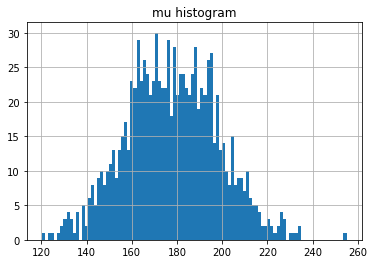

In [102]:
# Histogram of mu
mu = sim.stan_variable('mu')

plt.hist(mu,bins=100)
plt.title('mu histogram')
plt.grid()

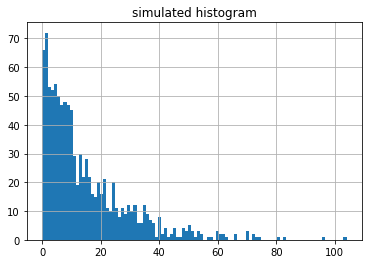

In [103]:
# Histogram of sigma
sigma = sim.stan_variable('sigma')

plt.hist(sigma,bins=100)
plt.title('simulated histogram')
plt.grid()

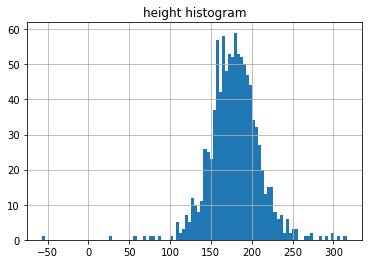

In [104]:
# Histogram of simulated height
height = sim.stan_variable('height')

plt.hist(height,bins=100)
plt.title('height histogram')
plt.grid()

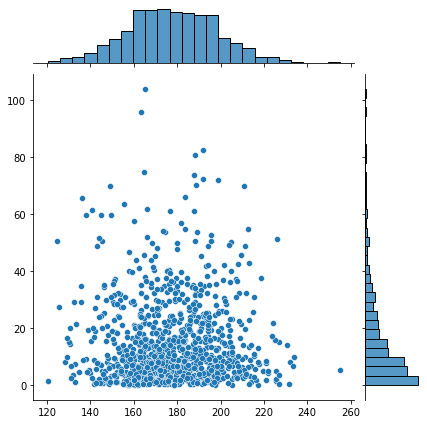

In [105]:
# Joint distribution of mu and sigma
sns.jointplot(data=sim, x=mu,y=sigma)

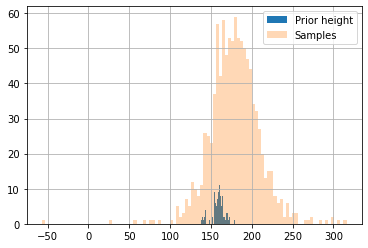

In [106]:
# Check if samples are consistent with priors
prior_height = d['height']

plt.hist(prior_height, bins=100)
plt.hist(height,bins=100, alpha=0.3)
plt.legend(['Prior height', 'Samples'])
plt.grid()
plt.show()

#### Task 2. Model fit and evaluation

1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.



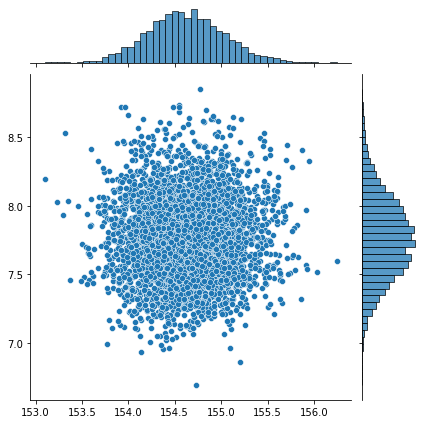

In [107]:
mu_fit = fit.stan_variable('mu')
sigma_fit = fit.stan_variable('sigma')
sns.jointplot(data=fit,x=mu_fit,y=sigma_fit)

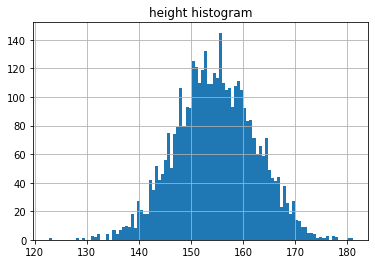

In [108]:
fit_height = fit.stan_variable('height')

plt.hist(fit_height,bins=100)
plt.title('height histogram')
plt.grid()

### Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [109]:
d['c_weight'] = d.weight-np.mean(d.weight)
d.head()

,height,weight,age,male,c_weight
0,151.765,47.825606,63.0,1,2.835121
1,139.700,36.485807,63.0,0,-8.504679
2,136.525,31.864838,65.0,0,-13.125648
3,156.845,53.041915,41.0,1,8.051429
4,145.415,41.276872,51.0,0,-3.713614


In [110]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')

R = 1000
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


#### Task 4. Prior predictive checks
1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

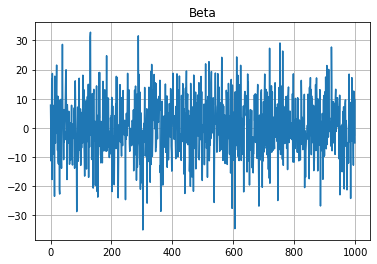

In [111]:
beta = sim.stan_variable('beta')
alpha = sim.stan_variable('alpha')

plt.plot(beta)
plt.title('Beta')
plt.grid()

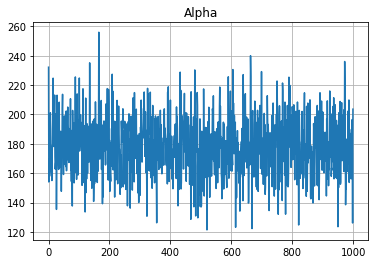

In [112]:
plt.plot(alpha)
plt.title('Alpha')
plt.grid()

### Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [113]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [114]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start procesing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


#### Task 5. Prior predictive checks
1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

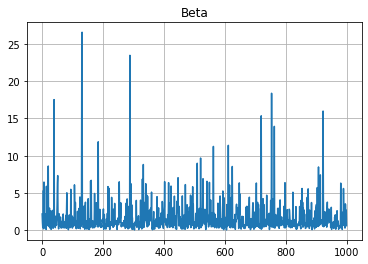

In [115]:
beta = sim.stan_variable('beta')
alpha = sim.stan_variable('alpha')

plt.plot(beta)
plt.title('Beta')
plt.grid()

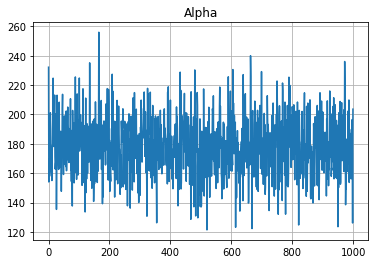

In [116]:
plt.plot(alpha)
plt.title('Alpha')
plt.grid()

In [117]:
print(sim.column_names)

('lp__', 'accept_stat__', 'alpha', 'beta', 'sigma', 'height[1]', 'height[2]', 'height[3]', 'height[4]', 'height[5]', 'height[6]', 'height[7]', 'height[8]', 'height[9]', 'height[10]', 'height[11]', 'height[12]', 'height[13]', 'height[14]', 'height[15]', 'height[16]', 'height[17]', 'height[18]', 'height[19]', 'height[20]', 'height[21]', 'height[22]', 'height[23]', 'height[24]', 'height[25]', 'height[26]', 'height[27]', 'height[28]', 'height[29]', 'height[30]', 'height[31]', 'height[32]', 'height[33]', 'height[34]', 'height[35]', 'height[36]', 'height[37]', 'height[38]', 'height[39]', 'height[40]', 'height[41]', 'height[42]', 'height[43]', 'height[44]', 'height[45]', 'height[46]', 'height[47]', 'height[48]', 'height[49]', 'height[50]')


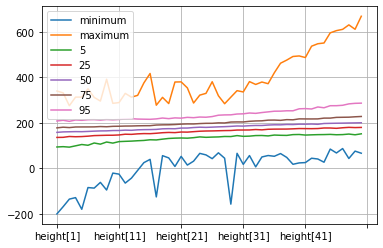

In [118]:
sim_height = sim.draws_pd()
sim_height.drop(columns=['lp__', 'accept_stat__', 'alpha', 'beta', 'sigma'],inplace=True)


data = {'minimum' : sim_height.min(),
        'maximum' : sim_height.max(),
        '5' : sim_height.quantile(0.05),
        '25' : sim_height.quantile(0.25),
        '50' : sim_height.quantile(0.5),
        '75' : sim_height.quantile(0.75),
        '95' : sim_height.quantile(0.95)}

sim_data = pd.DataFrame(data)
sim_data.plot()
plt.grid()

### Fitting data


In [119]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


#### Task 6. Preparing data for fit
1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe

In [131]:
n_val = 200
data_fit = {'N' : n_val, 
            'weight' : d['weight'][:n_val], 
            'heights' : d['height'][:n_val]}

fit=model_2_fit.sample(data=data_fit,seed=28052020)


INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████▌| 00:01 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:01 Iteration: 1900 / 2000 [ 95%]  (Sampling)


chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |██████████| 00:02 Sampling completed                       
chain 4 |██████████| 00:02 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


#### Task 7. Evaluating model

1. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


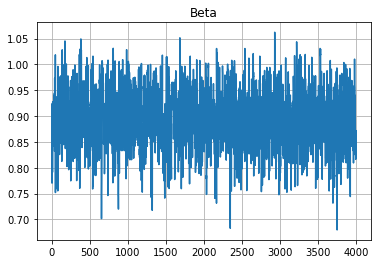

In [132]:
beta = fit.stan_variable('beta')
alpha = fit.stan_variable('alpha')

plt.plot(beta)
plt.title('Beta')
plt.grid()

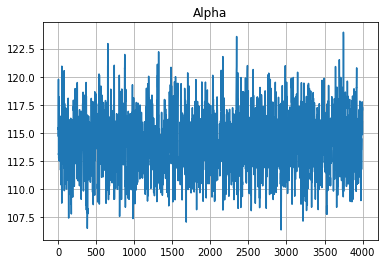

In [133]:
plt.plot(alpha)
plt.title('Alpha')
plt.grid()

In [134]:
print(fit.column_names)

('lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__', 'alpha', 'beta', 'sigma', 'mu[1]', 'mu[2]', 'mu[3]', 'mu[4]', 'mu[5]', 'mu[6]', 'mu[7]', 'mu[8]', 'mu[9]', 'mu[10]', 'mu[11]', 'mu[12]', 'mu[13]', 'mu[14]', 'mu[15]', 'mu[16]', 'mu[17]', 'mu[18]', 'mu[19]', 'mu[20]', 'mu[21]', 'mu[22]', 'mu[23]', 'mu[24]', 'mu[25]', 'mu[26]', 'mu[27]', 'mu[28]', 'mu[29]', 'mu[30]', 'mu[31]', 'mu[32]', 'mu[33]', 'mu[34]', 'mu[35]', 'mu[36]', 'mu[37]', 'mu[38]', 'mu[39]', 'mu[40]', 'mu[41]', 'mu[42]', 'mu[43]', 'mu[44]', 'mu[45]', 'mu[46]', 'mu[47]', 'mu[48]', 'mu[49]', 'mu[50]', 'mu[51]', 'mu[52]', 'mu[53]', 'mu[54]', 'mu[55]', 'mu[56]', 'mu[57]', 'mu[58]', 'mu[59]', 'mu[60]', 'mu[61]', 'mu[62]', 'mu[63]', 'mu[64]', 'mu[65]', 'mu[66]', 'mu[67]', 'mu[68]', 'mu[69]', 'mu[70]', 'mu[71]', 'mu[72]', 'mu[73]', 'mu[74]', 'mu[75]', 'mu[76]', 'mu[77]', 'mu[78]', 'mu[79]', 'mu[80]', 'mu[81]', 'mu[82]', 'mu[83]', 'mu[84]', 'mu[85]', 'mu[86]', 'mu[87]', 'mu[88]', 'mu[8

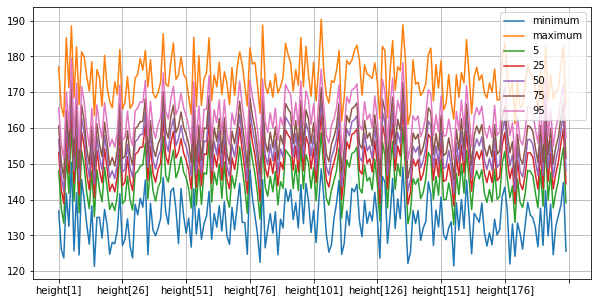

In [135]:
fit_height = fit.draws_pd()
fit_height = fit_height.loc[:,'height[1]':]


data2 = {'minimum' : fit_height.min(),
        'maximum' : fit_height.max(),
        '5' : fit_height.quantile(0.05),
        '25' : fit_height.quantile(0.25),
        '50' : fit_height.quantile(0.5),
        '75' : fit_height.quantile(0.75),
        '95' : fit_height.quantile(0.95)}

fit_data = pd.DataFrame(data2)
fit_data.plot(figsize=(10,5))
plt.grid()